# SPTrans: Mobilidade urbana durante o coronavírus

In [7]:
import os
import numpy as np
import html.parser
import urllib.request
import dateutil.parser
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
from datetime import datetime as dt


rdates = pd.date_range(start = '01/01/2018', end = '12/31/2020', freq = 'd')

tb = pd.read_excel(r'C:\Users\gusta\Documents\Projetos\SPtrans\sptrans.xlsx', parse_date = 'date')

tb = tb.pivot_table(index = tb.date.dt.year, columns = [tb.date.dt.month, tb.date.dt.day], values = 'total_passengers')\
        .pct_change().reset_index().melt(id_vars = 'date')\
        .dropna()\
        .assign(date = lambda x: (x.date.astype(str) + '-' +  x.variable_0.astype(str) + '-' + x.variable_1.astype(str)).apply(dt.strptime, args = ('%Y-%m-%d',)))\
        .merge(pd.DataFrame({'date':rdates}), on = 'date', how = 'outer')\
        .drop(['variable_0', 'variable_1'], axis = 1)\
        .rename(columns = {'value':'pc_change_yoy'})\
        .sort_values('date')

total = pd.read_excel(r'C:\Users\gusta\Documents\Projetos\SPtrans\sptrans.xlsx', parse_date = 'date')\
          .filter(['date', 'pc_change_yoy'])\
          .dropna()\
          .merge(pd.DataFrame({'date':rdates}), on = 'date', how = 'outer')\
          .sort_values('date')

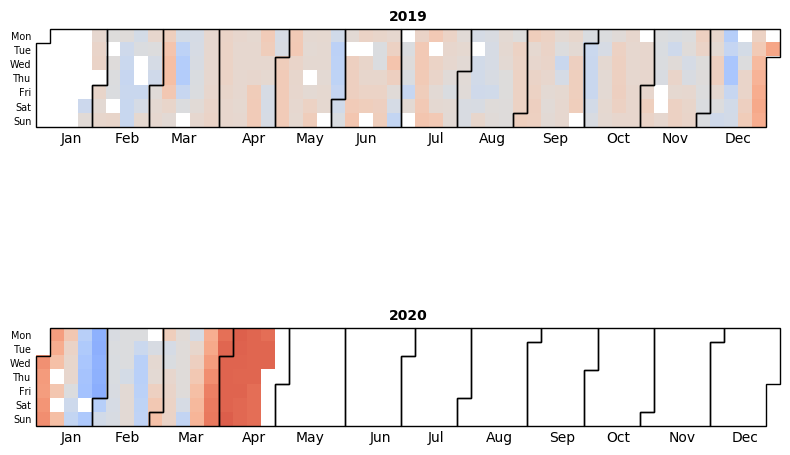

In [8]:
def calmap(ax, year, data, origin="upper", weekstart="sun"):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []

    start = datetime(year, 1, 1).weekday()

    _data = np.zeros(7 * 53) * np.nan
    _data[start:start + len(data)] = data
    data = _data.reshape(53, 7).T

    for month in range(1, 13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)
        if origin == "lower":
            y0 = first.weekday()
            y1 = last.weekday()
            x0 = (int(first.strftime("%j")) + start - 1) // 7
            x1 = (int(last.strftime("%j")) + start - 1) // 7
            P = [(x0, y0), (x0, 7), (x1, 7), (x1, y1 + 1),
                 (x1 + 1, y1 + 1), (x1 + 1, 0), (x0 + 1, 0), (x0 + 1, y0)]
        else:
            y0 = 6 - first.weekday()
            y1 = 6 - last.weekday()
            x0 = (int(first.strftime("%j")) + start - 1) // 7
            x1 = (int(last.strftime("%j")) + start - 1) // 7
            P = [(x0, y0 + 1), (x0, 0), (x1, 0), (x1, y1),
                 (x1 + 1, y1), (x1 + 1, 7), (x0 + 1, 7), (x0 + 1, y0 + 1)]

        xticks.append(x0 + (x1 - x0 + 1) / 2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)

    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))

    labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    if origin == "upper": labels = labels[::-1]
    ax.set_yticklabels(labels)
    ax.set_title("{}".format(year), size="medium", weight="bold")

    # Showing data
    cmap = plt.cm.get_cmap('coolwarm_r')
    ax.imshow(data, extent=[0, 53, 0, 7], zorder=10,
              vmin=-1, vmax=1, cmap=cmap, origin=origin)

fig = plt.figure(figsize=(8, 7.5), dpi=100)
year = 2019
n = 2
for i in range(n):
    ax = plt.subplot(n, 1, i + 1, xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
    calmap(ax, year + i, (total.query(f'date.dt.year == {year + i}').pc_change_yoy.values), origin="upper")

plt.tight_layout()
plt.savefig(r"C:\Users\gusta\Documents\Projetos\SPtrans\sptrans.svg", dpi=300, transparent = True, format = 'svg')
# plt.colorbar()
plt.show()

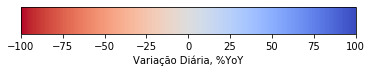

In [9]:
# ================================================================================================================================
# # Colormap
# ================================================================================================================================

import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = plt.cm.get_cmap('coolwarm_r')
norm = mpl.colors.Normalize(vmin=-100, vmax=100)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Variação Diária, %YoY')

plt.savefig(r"C:\Users\gusta\Downloads\Macro\colorbar.svg", dpi=300, transparent = True, format = 'svg')
plt.show()





